In [1]:
import sys
from ri_ssim import micro_SSIM
from disentangle.core.tiff_reader import load_tiff
from collections import defaultdict
from tqdm import tqdm
from ri_ssim.ri_ssim import mse_based_range_invariant_structural_similarity
from disentangle.analysis.plot_utils import add_pixel_kde, clean_ax, add_subplot_axes
import os
from matplotlib import patches
import seaborn as sns
from disentangle.analysis.plot_utils import clean_ax
import os
from ri_ssim.ri_ssim import _ssim_from_params, structural_similarity_dict
from tqdm import tqdm
import numpy as np
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt


/localscratch/miniforge3/envs/usplit_vdi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# gt_path = '/group/jug/ashesh/ri_ssim/gt-N2V-2402-31.tif'
# pred_path = '/group/jug/ashesh/ri_ssim/pred-N2V-2402-31.tif'
# noisy_gt_path = '/group/jug/ashesh/data/ventura_gigascience/actin-60x-noise2-lowsnr.tif'

gt_path = '/group/jug/ashesh/ri_ssim/gt-N2V-2402-29.tif'
pred_path = '/group/jug/ashesh/ri_ssim/pred-N2V-2402-29.tif'
noisy_gt_path = '/group/jug/ashesh/data/ventura_gigascience/mito-60x-noise2-lowsnr.tif'

In [3]:
debug_mode = False
gt = load_tiff(gt_path)
pred = load_tiff(pred_path)
gt_lowsnr = load_tiff(noisy_gt_path)

In [4]:
gt_lowsnr.shape 

(100, 2048, 2048)

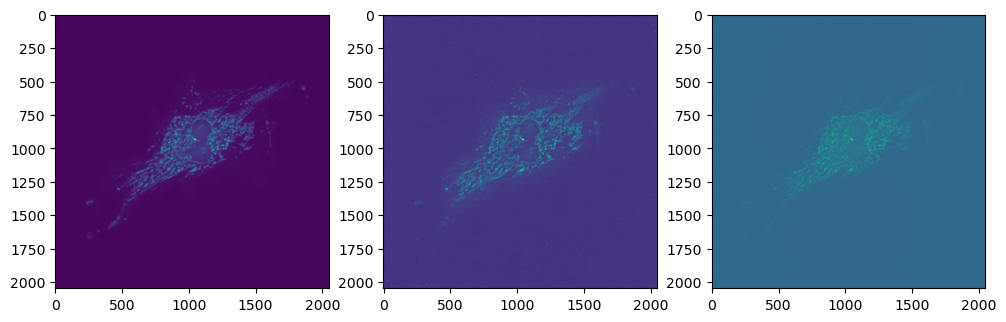

In [5]:
_,ax = plt.subplots(figsize=(12,4),ncols=3)
ax[0].imshow(gt[15])
ax[1].imshow(pred[15])
ax[2].imshow(gt_lowsnr[15])

In [4]:
from ri_ssim._ssim_raw import structural_similarity_dict
from ri_ssim._mse_ri_factor import get_mse_based_factor
import numpy as np
from scipy.optimize import minimize
from typing import Dict, Union


def _ssim_from_params(
    scaling_params, ux, uy, vx, vy, vxy, C1, C2, return_individual_components=False
):
    if len(scaling_params) == 2:
        alpha, beta = scaling_params
    else:
        assert len(scaling_params) == 1
        alpha = scaling_params[0]
        beta = 0

    A1, A2, B1, B2 = (
        2 *  ux * (alpha *uy + beta) + C1,
        2 * alpha * vxy + C2,
        ux**2 + (alpha *uy + beta)**2 + C1,
        vx + (alpha**2) * vy + C2,
    )
    D = B1 * B2
    S = (A1 * A2) / D

    if return_individual_components:
        term = 2 * alpha * np.sqrt(vx * vy) + C2
        luminance = A1 / B1
        contrast = term / B2
        structure = A2 / term
        return {
            "SSIM": S,
            "luminance": luminance,
            "contrast": contrast,
            "structure": structure,
            "alpha": alpha,
        }

    return np.mean(S)


def get_ri_factor(ssim_dict: Dict[str, np.ndarray], fixed_offset=True):
    other_args = (
        ssim_dict["ux"],
        ssim_dict["uy"],
        ssim_dict["vx"],
        ssim_dict["vy"],
        ssim_dict["vxy"],
        ssim_dict["C1"],
        ssim_dict["C2"],
    )
    if fixed_offset:
        initial_guess = np.array([1])
    else:
        initial_guess = np.array([1, 0.0])
    
    res = minimize(
        lambda *args: -1 * _ssim_from_params(*args), initial_guess, args=other_args
    )
    
    if fixed_offset:
        return res.x
    else:
        return res.x


def mse_based_range_invariant_structural_similarity(
    target_img,
    pred_img,
    *,
    win_size=None,
    data_range=None,
    channel_axis=None,
    gaussian_weights=False,
    return_individual_components=False,
    **kwargs,
):
    ri_factor = get_mse_based_factor(target_img[None], pred_img[None])

    return micro_SSIM(
        target_img,
        pred_img,
        win_size=win_size,
        data_range=data_range,
        channel_axis=channel_axis,
        gaussian_weights=gaussian_weights,
        ri_factor=ri_factor,
        return_individual_components=return_individual_components,
        **kwargs,
    )


def micro_SSIM(
    target_img,
    pred_img,
    *,
    win_size=None,
    data_range=None,
    channel_axis=None,
    gaussian_weights=False,
    ri_factor: Union[float, None] = None,
    return_individual_components: bool = False,
    fixed_offset:bool = True,
    **kwargs,
):
    ssim_dict = structural_similarity_dict(
        target_img,
        pred_img,
        win_size=win_size,
        data_range=data_range,
        channel_axis=channel_axis,
        gaussian_weights=gaussian_weights,
        **kwargs,
    )
    if ri_factor is None:
        ri_factor = get_ri_factor(ssim_dict, fixed_offset=fixed_offset)
    ux, uy, vx, vy, vxy, C1, C2 = (
        ssim_dict["ux"],
        ssim_dict["uy"],
        ssim_dict["vx"],
        ssim_dict["vy"],
        ssim_dict["vxy"],
        ssim_dict["C1"],
        ssim_dict["C2"],
    )

    return _ssim_from_params(
        ri_factor,
        ux,
        uy,
        vx,
        vy,
        vxy,
        C1,
        C2,
        return_individual_components=return_individual_components,
    )

In [29]:
ri_factors = []
for i in range(0, 100, 10):
    gt_tmp = gt[i] - np.quantile(gt[i], 0.05)
    pred_tmp = pred[i] - np.quantile(pred[i], 0.05)

    ssim_dict = structural_similarity_dict(
        gt_tmp,
        pred_tmp,
        data_range=gt_tmp.max() - gt_tmp.min(),
    )
    ri_factor = get_ri_factor(ssim_dict, fixed_offset=True)
    ri_factors.append(ri_factor)
    ux, uy, vx, vy, vxy, C1, C2 = (
            ssim_dict["ux"],
            ssim_dict["uy"],
            ssim_dict["vx"],
            ssim_dict["vy"],
            ssim_dict["vxy"],
            ssim_dict["C1"],
            ssim_dict["C2"],
        )

    print(_ssim_from_params(
            ri_factor,
            ux,
            uy,
            vx,
            vy,
            vxy,
            C1,
            C2
        ))

0.8592474117197939
0.8120457355421167
0.842693250490507
0.8063689865284607
0.8138304870698692
0.8378262434372676
0.8545814868713396
0.858243735246012
0.9372845244222754
0.8321714814368503


In [30]:
ri_factors

[array([15.06538042]),
 array([23.25705207]),
 array([16.51602302]),
 array([33.82547328]),
 array([13.91974485]),
 array([21.18370828]),
 array([16.71559431]),
 array([22.40690493]),
 array([14.25009672]),
 array([13.9198435])]

In [ ]:
### with fixed offset
0.9041594629209673
0.8329269444012247
0.8811175541920527
0.8264723004208812
0.8887926962732787
0.8714344585465807
0.8819690179508839
0.8874700212892815
0.9517414213500792
0.8973414103086156

[array([9.81790954]),
 array([8.3010692]),
 array([8.6918834]),
 array([6.07084246]),
 array([16.1963213]),
 array([9.90101915]),
 array([9.75713945]),
 array([7.25127225]),
 array([6.4332293]),
 array([14.33503131])]

with fixed offset, but with 0.05 quantile q removed from the images
0.8592474117197939
0.8120457355421167
0.842693250490507
0.8063689865284607
0.8138304870698692
0.8378262434372676
0.8545814868713396
0.858243735246012
0.9372845244222754
0.8321714814368503

[array([15.06538042]),
 array([23.25705207]),
 array([16.51602302]),
 array([33.82547328]),
 array([13.91974485]),
 array([21.18370828]),
 array([16.71559431]),
 array([22.40690493]),
 array([14.25009672]),
 array([13.9198435])]

In [ ]:
without fixed offset, but with 0.05 q removed from gt and pred
0.8607971104863832
0.8262009702309803
0.8476528971447607
0.8272497748224823
0.8145843487433087
0.8518906456799301
0.8624182333361914
0.8686402251579387
0.9404466732576635
0.8331697589894078

[array([19.02008311, -3.5199759 ]),
 array([ 36.02889041, -12.26122782]),
 array([23.59954822, -6.4618703 ]),
 array([ 58.45687655, -23.69574567]),
 array([16.64799851, -2.24802075]),
 array([ 35.35646062, -13.28424787]),
 array([25.15357002, -8.25807068]),
 array([ 34.83860672, -11.88333632]),
 array([22.34818059, -7.53818787]),
 array([17.11422216, -2.66337952])]

## Inspecting individual elements: luminance, contrast and structure

In [19]:

idx_list  = list(range(0,100,10))
idx = idx_list[0]
dicts = defaultdict(list)
for idx in tqdm(idx_list):
    for remove_min in [True, False]:
        gt_tmp = gt[idx] - gt[idx].min() * remove_min
        gt_tmp_lowsnr = gt_lowsnr[idx] - gt_lowsnr[idx].min() * remove_min
        pred_tmp = pred[idx] - pred[idx].min() * remove_min
        ssim_comp_dict = micro_SSIM(gt_tmp, pred_tmp, ri_factor=None, data_range=gt_tmp.max() - gt_tmp.min(), return_individual_components=True)
        dicts[remove_min].append(ssim_comp_dict)
        assert np.abs(ssim_comp_dict['SSIM'] - (ssim_comp_dict['luminance'] * ssim_comp_dict['contrast'] * ssim_comp_dict['structure'])).max() < 1e-10

100%|██████████| 10/10 [00:27<00:00,  2.76s/it]


## MSE based scaling SSIM

In [21]:

dicts_mse = defaultdict(list)
for idx in tqdm(idx_list):
    for remove_min in [True, False]:
        gt_tmp = gt[idx] - gt[idx].min() * remove_min
        gt_tmp_lowsnr = gt_lowsnr[idx] - gt_lowsnr[idx].min() * remove_min
        pred_tmp = pred[idx] - pred[idx].min() * remove_min
        ssim_comp_dict = mse_based_range_invariant_structural_similarity(gt_tmp, 
                                                                         pred_tmp, 
                                                                         data_range=gt_tmp.max() - gt_tmp.min(), 
                                                                         return_individual_components=True)
        dicts_mse[remove_min].append(ssim_comp_dict)
        assert np.abs(ssim_comp_dict['SSIM'] - (ssim_comp_dict['luminance'] * ssim_comp_dict['contrast'] * ssim_comp_dict['structure'])).max() < 1e-10

100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


## No scaling.

In [22]:
dicts_None = defaultdict(list)
for idx in tqdm(idx_list):
    for remove_min in [True, False]:
        gt_tmp = gt[idx] - gt[idx].min() * remove_min
        gt_tmp_lowsnr = gt_lowsnr[idx] - gt_lowsnr[idx].min() * remove_min
        pred_tmp = pred[idx] - pred[idx].min() * remove_min
        ssim_comp_dict = micro_SSIM(gt_tmp, 
                                                                         pred_tmp, 
                                                                            ri_factor=1.0,
                                                                         data_range=gt_tmp.max() - gt_tmp.min(), 
                                                                         return_individual_components=True)
        dicts_None[remove_min].append(ssim_comp_dict)
        assert np.abs(ssim_comp_dict['SSIM'] - (ssim_comp_dict['luminance'] * ssim_comp_dict['contrast'] * ssim_comp_dict['structure'])).max() < 1e-10

100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


In [68]:
# q_arr = [0.5, 0.7]
# for q in q_arr:
#     factor_list = []
#     for i in range(len(gt)):
#         gt_tmp  = gt[i] - np.quantile(gt[i], 0.05)
#         pred_tmp = pred[i] - np.quantile(pred[i], 0.05)
#         factor_list.append(np.quantile(gt_tmp, q)/np.quantile(pred_tmp, q))

#     factor_list = np.array(factor_list)
#     print(q, np.mean(factor_list[idx_list]), np.std(factor_list[idx_list]))

# plt.imshow(gt[0]>np.quantile(tmp_gt, 0.7))

In [49]:
alpha_ssim = []
alpha_mse = []
for i in range(len(idx_list)):
    alpha_ssim.append(dicts[True][i]['alpha'])
    alpha_mse.append(dicts_mse[True][i]['alpha'][0,0])

print('SSIM', np.mean(alpha_ssim), np.std(alpha_ssim))
print('MSE', np.mean(alpha_mse), np.std(alpha_mse))

SSIM 9.675567802820437 3.107231104657514
MSE 19.904527106693973 3.8059639539160743


In [25]:
for i in range(len(idx_list)):
    print(dicts[True][i]['SSIM'].mean(), dicts_mse[True][i]['SSIM'].mean(), dicts_None[True][i]['SSIM'].mean())

0.9041594629209673 0.7485328838999163 0.32639403975579023
0.8329269444012248 0.6169926183679383 0.3573565854213054
0.8811175541819656 0.695520918043257 0.325906036282182
0.8264723004202849 0.5524998931164604 0.48593898612868686
0.8887926962253331 0.8256748127227376 0.18771012635439802
0.8714344585470093 0.6891050480161937 0.3887614153258078
0.8819690179507511 0.6677421753786957 0.37903498140461195
0.8874700212975892 0.7235099182956215 0.40454652113335743
0.951741421350438 0.8436642358253758 0.5204971442923838
0.8973414102895753 0.8457794216624864 0.21107616108380417


/group/jug/ashesh/ri_ssim/images/bkg_ablation_Idx10_raw_predictions_N2V-2402-31.png


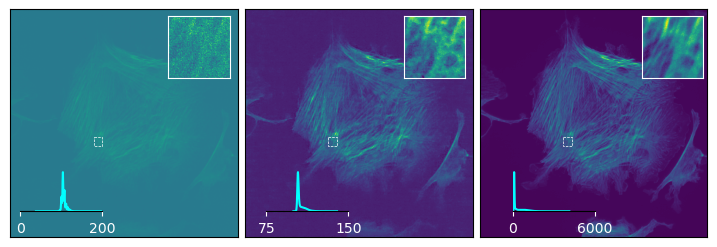

In [83]:


def boundary_color(ax_cur, color):
    for spine in ax_cur.spines.values():
        spine.set_edgecolor(color)

save_to_file = True and not debug_mode
ith_img= 1

idx = idx_list[ith_img]
zoomin_hw = [(700, 750), (1150, 750), (750, 450)][ith_img]
_,ax = plt.subplots(figsize=(9,3),ncols=3)
ax[0].imshow(gt_lowsnr[idx])
ax[1].imshow(pred[idx])
ax[2].imshow(gt[idx])

# zoomin rectangles
zoomin_h,zoomin_w = zoomin_hw
zoomin_sz = 80
rect = patches.Rectangle((zoomin_w, zoomin_h), zoomin_sz,zoomin_sz, 
                         linewidth=0.5, edgecolor='w', facecolor='none', linestyle='--')
ax[0].add_patch(rect)
rect = patches.Rectangle((zoomin_w, zoomin_h), zoomin_sz,zoomin_sz, 
                         linewidth=0.5, edgecolor='w', facecolor='none', linestyle='--')
ax[1].add_patch(rect)

rect = patches.Rectangle((zoomin_w, zoomin_h), zoomin_sz,zoomin_sz, 
                         linewidth=0.5, edgecolor='w', facecolor='none', linestyle='--')
ax[2].add_patch(rect)

# zoomin patches
zoomin_rect = [0.77, 0.72, 0.3, 0.3]
zoomin_ax = add_subplot_axes(ax[0], zoomin_rect, facecolor = 'w', min_labelsize = 5)
zoomin_ax.imshow(gt_lowsnr[idx][zoomin_h:zoomin_h+zoomin_sz,zoomin_w:zoomin_w+zoomin_sz])
clean_ax(zoomin_ax)
boundary_color(zoomin_ax, 'white')

zoomin_rect = [0.72, 0.72, 0.3, 0.3]
zoomin_ax = add_subplot_axes(ax[1], zoomin_rect, facecolor = 'w', min_labelsize = 5)
zoomin_ax.imshow(pred[idx][zoomin_h:zoomin_h+zoomin_sz,zoomin_w:zoomin_w+zoomin_sz])
clean_ax(zoomin_ax)
boundary_color(zoomin_ax, 'white')

zoomin_rect = [0.68, 0.72, 0.3, 0.3]
zoomin_ax = add_subplot_axes(ax[2], zoomin_rect, facecolor = 'w', min_labelsize = 5)
zoomin_ax.imshow(gt[idx][zoomin_h:zoomin_h+zoomin_sz,zoomin_w:zoomin_w+zoomin_sz])
clean_ax(zoomin_ax)
boundary_color(zoomin_ax, 'white')



color_ch = 'cyan'
# color_pred = 'red'
inset_min_labelsize = 10
hist_inset_rect = [0.05, 0.07, 0.4, 0.2]
fac = 1 if save_to_file else 4
add_pixel_kde(ax[0],
                  hist_inset_rect,
                  [gt_lowsnr[idx][::fac,::fac]],
                  inset_min_labelsize,
                  color_list=[color_ch],
                  label_list = [''])




add_pixel_kde(ax[1],
                  hist_inset_rect,
                  [pred[idx][::fac,::fac]],
                  inset_min_labelsize,
                  color_list=[color_ch],
                  label_list = [''])

add_pixel_kde(ax[2],
                  hist_inset_rect,
                  [gt[idx][::fac,::fac]],
                  inset_min_labelsize,
                  color_list=[color_ch],
                  label_list = [''])

clean_ax(ax)
plt.subplots_adjust(wspace=0.03, hspace=0.03)
if save_to_file:
    postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'bkg_ablation_Idx{idx}_raw_predictions_{postfix}'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    # plt.tight_layout()
    plt.savefig(fpath, dpi=200)

In [84]:

def add_text(ax, text, img_shape, off0=0, off1=0,place='TOP_LEFT', facecolor='white', edgecolor='black'):
    """
    Adding text on image
    """
    assert place in ['TOP_LEFT', 'BOTTOM_RIGHT']
    if place == 'TOP_LEFT':
        ax.text(img_shape[1] * 15 / 500 + off0, img_shape[0] * 55 / 500 + off1, text, bbox=dict(facecolor=facecolor, edgecolor=edgecolor, alpha=0.9))
    elif place == 'BOTTOM_RIGHT':
        s0 = img_shape[1]
        s1 = img_shape[0]
        ax.text(s0 - s0 * 150 / 500 + off0, s1 - s1 * 35 / 500 + off1, text, bbox=dict(facecolor=facecolor,edgecolor=edgecolor, alpha=0.9))


/group/jug/ashesh/ri_ssim/images/bkg_ablation_Idx2_N2V-2402-31.png


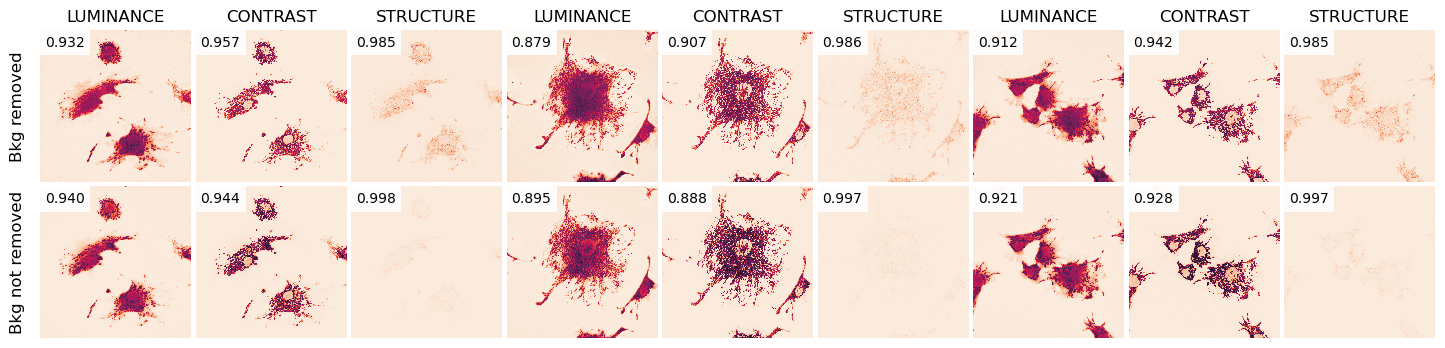

In [85]:

num_samples = 3

shape = list(dicts[True][0]['luminance'].shape)
fac = 1 if save_to_file else 4
img_sz = 2
_,ax = plt.subplots(figsize=(img_sz*3*num_samples,img_sz*2),ncols=3*num_samples,nrows=2)

for idx in range(num_samples):
# For True
    for i, key in enumerate(['luminance', 'contrast', 'structure']):
        sns.heatmap(dicts[True][idx][key][::fac,::fac],vmin=0,vmax=1,ax=ax[0,3*idx + i], cbar=False)
        val = f"{dicts[True][idx][key][::fac,::fac].mean():.3f}"
        add_text(ax[0,3*idx + i], val, (shape[0]//fac, shape[1]//fac), edgecolor='none')

    # For False
    for i, key in enumerate(['luminance', 'contrast', 'structure']):
        sns.heatmap(dicts[False][idx][key][::fac,::fac],vmin=0,vmax=1,ax=ax[1,3*idx + i], cbar=False)
        val = f"{dicts[False][idx][key][::fac,::fac].mean():.3f}"
        add_text(ax[1,3*idx + i], val, (shape[0]//fac, shape[1]//fac), edgecolor='none')

    ax[0,idx*3 + 0].set_title('Luminance'.upper())
    ax[0,idx*3 + 1].set_title('Contrast'.upper())
    ax[0,idx*3 + 2].set_title('Structure'.upper())


clean_ax(ax)


alpha_true = round(dicts[True][idx]['alpha'],2)
ax[0,0].set_ylabel('Bkg removed', fontsize=12)

alpha_false = round(dicts[False][idx]['alpha'],2)
ax[1,0].set_ylabel('Bkg not removed', fontsize=12)

plt.subplots_adjust(wspace=0.03, hspace=0.03)
# plt.tight_layout()
if save_to_file:
    postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'bkg_ablation_Idx{idx}_{postfix}'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    # plt.tight_layout()
    plt.savefig(fpath, dpi=200)


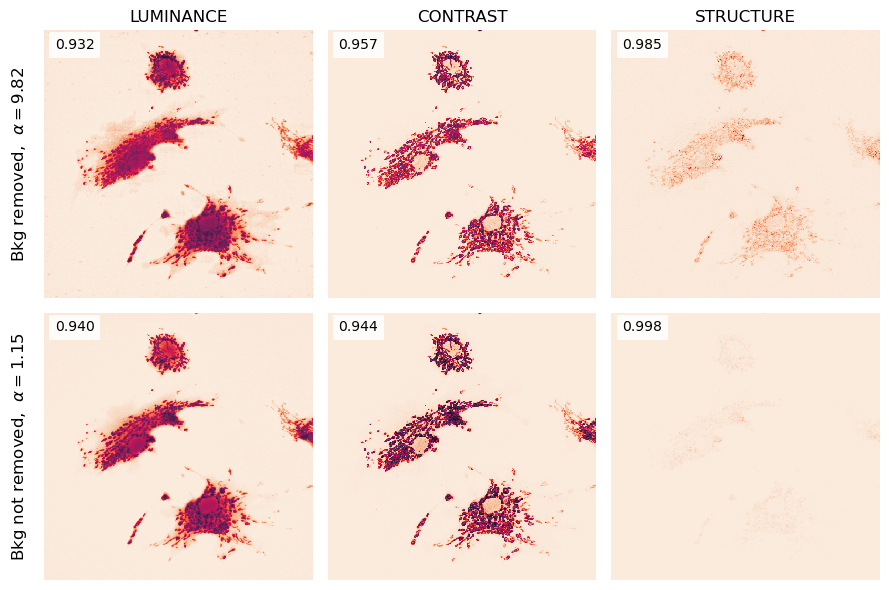

In [10]:
# import seaborn as sns
# from disentangle.analysis.plot_utils import clean_ax
# import os
# idx = idx_list[0]

# shape = list(dicts[True][idx]['luminance'].shape)
# fac = 1 if save_to_file else 4
# img_sz = 2
# _,ax = plt.subplots(figsize=(img_sz*3,img_sz*2),ncols=3,nrows=2)

# # For True
# for i, key in enumerate(['luminance', 'contrast', 'structure']):
#     sns.heatmap(dicts[True][idx][key][::fac,::fac],vmin=0,vmax=1,ax=ax[0,i], cbar=False)
#     val = f"{dicts[True][idx][key][::fac,::fac].mean():.3f}"
#     add_text(ax[0,i], val, (shape[0]//fac, shape[1]//fac), edgecolor='none')

# # For False
# for i, key in enumerate(['luminance', 'contrast', 'structure']):
#     sns.heatmap(dicts[False][idx][key][::fac,::fac],vmin=0,vmax=1,ax=ax[1,i], cbar=False)
#     val = f"{dicts[False][idx][key][::fac,::fac].mean():.3f}"
#     add_text(ax[1,i], val, (shape[0]//fac, shape[1]//fac), edgecolor='none')


# clean_ax(ax)
# ax[0,0].set_title('Luminance'.upper())
# ax[0,1].set_title('Contrast'.upper())
# ax[0,2].set_title('Structure'.upper())

# alpha_true = round(dicts[True][idx]['alpha'],2)
# ax[0,0].set_ylabel('Bkg removed,  ' + f'$\\alpha=${alpha_true}', fontsize=12)

# alpha_false = round(dicts[False][idx]['alpha'],2)
# ax[1,0].set_ylabel('Bkg not removed,  ' + f'$\\alpha=${alpha_false}', fontsize=12)

# plt.subplots_adjust(wspace=0, hspace=0)
# plt.tight_layout()
# if save_to_file:
#     postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
#     fname = f'bkg_ablation_Idx{idx}_{postfix}'
#     fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
#     print(fpath)
#     plt.tight_layout()
#     plt.savefig(fpath, dpi=200)


### Inspecting background on differently intense pixels

0.01 100.0 0.8819761834741261 0.891064630414793
0.1 106.0 0.8765054352384721 0.8853438169287718
0.5 119.0 0.8403274200225048 0.8476609253547643
0.9 446.0 0.8173962524119904 0.8237777719085825
0.95 667.0 0.8162407412716609 0.8222319122160778


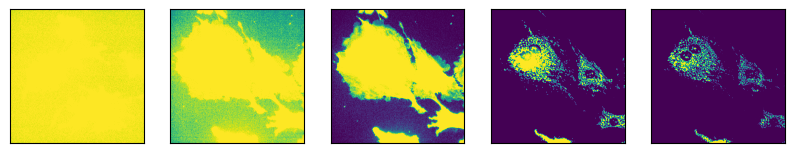

In [32]:
q_list = [0.01, 0.1, 0.5, 0.9,0.95]
imgsz = 2
_,ax = plt.subplots(figsize=(imgsz * len(q_list), imgsz), ncols=len(q_list))
padx = pady = None
for ax_idx, q_ in enumerate(q_list):
    q_val = np.quantile(gt[idx], q_)
    mask = gt[idx] > q_val
    ax[ax_idx].imshow(mask)
    if padx is None:
        padx, pady = (np.array(mask.shape) - np.array(dicts[True][0]['SSIM'].shape) )//2

    mask = mask[pady:-pady,padx:-padx]
    
    ssim_true = 0
    ssim_false = 0
    for idx in range(len(dicts[True])):
        ssim_true += dicts[True][idx]['SSIM'][mask].mean()
        ssim_false += dicts[False][idx]['SSIM'][mask].mean()
    
    ssim_true /= len(dicts[True])
    ssim_false /= len(dicts[False])
    print(q_,q_val, ssim_true, ssim_false)

clean_ax(ax)

## Background levels 

In [12]:
# from ri_ssim.ri_ssim import _ssim_from_params, structural_similarity_dict, _get_ri_factor
# q_min = 0.1
# idx = np.random.choice(len(gt))
# gt_cur = gt[idx] - np.quantile(gt[idx], q_min)
# pred_cur = pred[idx] - np.quantile(pred[idx], q_min)
# gt_cur[gt_cur < 0] = 0
# pred_cur[pred_cur < 0] = 0

# ssim_dict = structural_similarity_dict(
#     gt_cur,
#     pred_cur,
#     data_range=gt_cur.max() - gt_cur.min())

# ri_factor = _get_ri_factor(ssim_dict)
# ux, uy, vx, vy, vxy, C1, C2 = (
#     ssim_dict["ux"],
#     ssim_dict["uy"],
#     ssim_dict["vx"],
#     ssim_dict["vy"],
#     ssim_dict["vxy"],
#     ssim_dict["C1"],
#     ssim_dict["C2"],
# )
# raw_dict = _ssim_from_params(
#     ri_factor,
#     ux,
#     uy,
#     vx,
#     vy,
#     vxy,
#     C1,
#     C2,
#     return_individual_components=True,
# )

# q_vals = np.quantile(gt_tmp, [0,0.01,0.05,0.1,0.9, 0.95, 0.99])
# for qv in q_vals:
#     mask = gt_cur > np.quantile(gt_cur, qv)


# Manual varying of alpha: inspecting its uniqueness

(200, 2)

In [32]:


save_to_file = False and not debug_mode

ssim_components = defaultdict(list)
idx_list = []
# alpha_list = np.concatenate([np.arange(0,300,5)])
alpha_list =np.arange(0,200,10).reshape(-1,1)
# offset_list = np.arange(-200,100,2)
# scaling_params = np.stack(np.meshgrid(alpha_list, offset_list)).reshape(2,-1).T
scaling_params = alpha_list
num_idx = 2
for idx in np.random.choice(len(gt), size=num_idx, replace=False):
    idx_list.append(idx)
    gt_cur = gt[idx] - np.quantile(gt[idx], 0.05) #gt[idx].min()
    pred_cur = pred[idx] - np.quantile(pred[idx], 0.05) #pred[idx].min(
    random_pred = np.random.rand(*gt_cur.shape)
    random_pred = random_pred - random_pred.min()


    ssim_dict = structural_similarity_dict(
        gt_cur,
        pred_cur,
        data_range=gt_cur.max() - gt_cur.min())

    ux, uy, vx, vy, vxy, C1, C2 = (
        ssim_dict["ux"],
        ssim_dict["uy"],
        ssim_dict["vx"],
        ssim_dict["vy"],
        ssim_dict["vxy"],
        ssim_dict["C1"],
        ssim_dict["C2"],
    )

    ssim_arr = []
    luminance_arr = []
    contrast_arr = []
    structure_arr = []
    for factor in tqdm(scaling_params):
        ssim_dict = _ssim_from_params(factor, ux, uy, vx, vy, vxy, C1, C2, return_individual_components=True)
        ssim_arr.append(ssim_dict['SSIM'].mean())
        luminance_arr.append(ssim_dict['luminance'].mean())
        contrast_arr.append(ssim_dict['contrast'].mean())
        structure_arr.append(ssim_dict['structure'].mean())
    
    ssim_components['ssim'].append(ssim_arr)
    ssim_components['luminance'].append(luminance_arr)
    ssim_components['contrast'].append(contrast_arr)
    ssim_components['structure'].append(structure_arr)
    

100%|██████████| 20/20 [00:01<00:00, 15.98it/s]


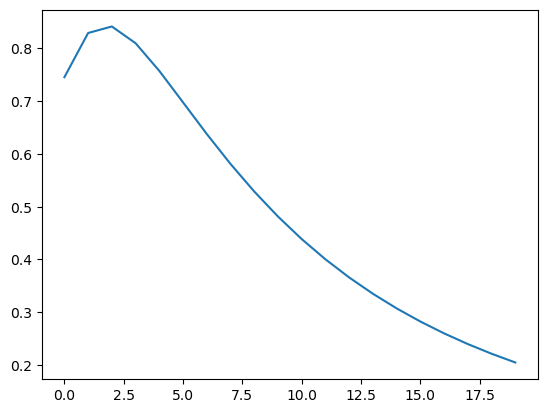

In [33]:
plt.plot(ssim_components['ssim'][0], label='SSIM')

<Axes: >

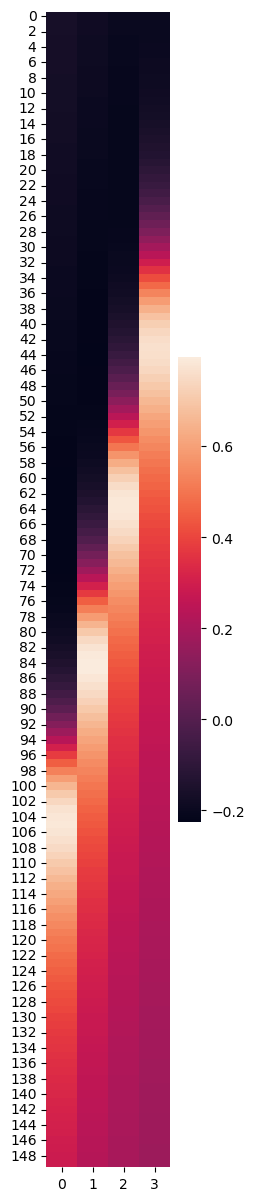

In [30]:
import seaborn as sns
_,ax = plt.subplots(figsize=(2,15))
sns.heatmap(np.array(ssim_components['ssim'][0]).reshape(150,4), annot=False)

/group/jug/ashesh/ri_ssim/images/ssim_uniqueness_Idx99_N2V-2402-29.png


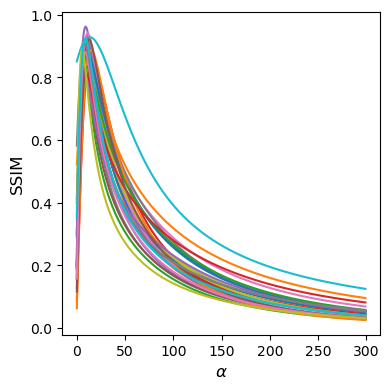

In [91]:

_,ax = plt.subplots(figsize=(4,4))
pd.DataFrame(np.stack(ssim_components['ssim']).T, index=alpha_list).plot(legend=False, ax=ax)
ax.set_xlabel('$\\alpha$', fontsize=12)
ax.set_ylabel('SSIM', fontsize=12)
if save_to_file:
    postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'ssim_uniqueness_Idx{idx}_{postfix}'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    plt.tight_layout()
    plt.savefig(fpath, dpi=200)


# Manual varying of alpha: inspecting the components

In [16]:


gt_cur = gt[idx] - gt[idx].min()
pred_cur = pred[idx] - pred[idx].min()
random_pred = np.random.rand(*gt_cur.shape)
random_pred = random_pred - random_pred.min()

pred_list = [pred_cur, pred_cur[::-1], pred_cur[:,::-1], pred_cur[::-1,::-1], random_pred]
# alpha_list = np.concatenate([np.arange(0.03,20,0.03),np.arange(20,100,0.1), np.arange(100,300,1), np.arange(300,1000,3)])
alpha_list = np.concatenate([np.arange(0.03,10,0.4)])
ssim_components = defaultdict(list)

for pred_tmp in pred_list:
    ssim_dict = structural_similarity_dict(
        gt_cur,
        pred_tmp,
        data_range=gt_cur.max() - gt_cur.min())

    ux, uy, vx, vy, vxy, C1, C2 = (
        ssim_dict["ux"],
        ssim_dict["uy"],
        ssim_dict["vx"],
        ssim_dict["vy"],
        ssim_dict["vxy"],
        ssim_dict["C1"],
        ssim_dict["C2"],
    )

    ssim_arr = []
    luminance_arr = []
    contrast_arr = []
    structure_arr = []
    for factor in tqdm(alpha_list):
        ssim_dict = _ssim_from_params(factor, ux, uy, vx, vy, vxy, C1, C2, return_individual_components=True)
        ssim_arr.append(ssim_dict['SSIM'].mean())
        luminance_arr.append(ssim_dict['luminance'].mean())
        contrast_arr.append(ssim_dict['contrast'].mean())
        structure_arr.append(ssim_dict['structure'].mean())
    
    ssim_components['ssim'].append(ssim_arr)
    ssim_components['luminance'].append(luminance_arr)
    ssim_components['contrast'].append(contrast_arr)
    ssim_components['structure'].append(structure_arr)
    

100%|██████████| 25/25 [00:01<00:00, 17.98it/s]


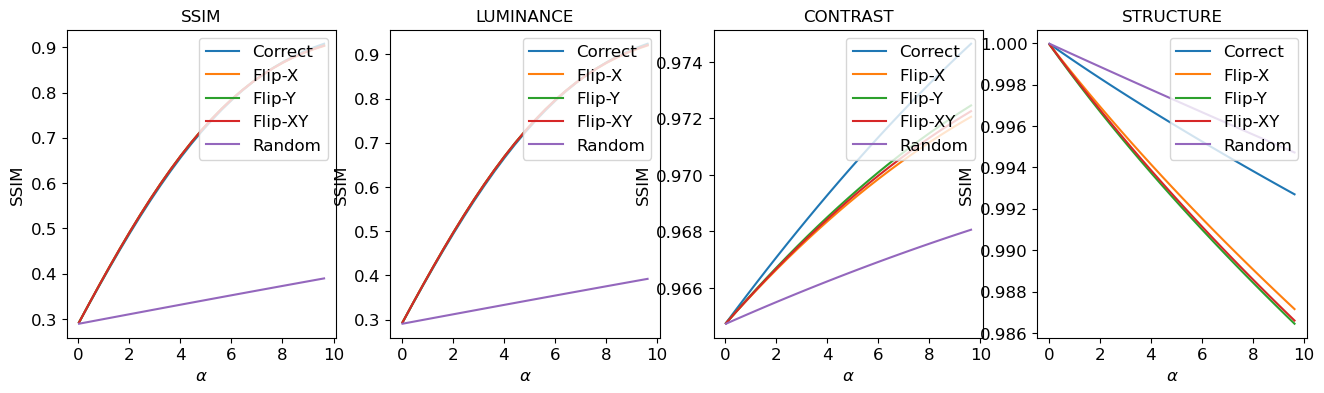

In [17]:

save_to_file = False and not debug_mode

_,ax = plt.subplots(figsize=(16,4),ncols=4)
for i, key in enumerate(['ssim','luminance','contrast','structure']):
    df = pd.DataFrame(np.stack(ssim_components[key]).T, columns = ['Correct', 'Flip-X', 'Flip-Y', 'Flip-XY', 'Random'], index =alpha_list)
    df.plot(fontsize=12, ax=ax[i]).legend(loc='upper right', fontsize=12)
    ax[i].set_title(key.upper(), fontsize=12)

for i in range(4):
    ax[i].set_xlabel('$\\alpha$', fontsize=12)
    ax[i].set_ylabel('SSIM', fontsize=12)

if save_to_file:
    postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'ssim_components_Idx{idx}_{postfix}'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    plt.tight_layout()
    plt.savefig(fpath, dpi=200)

In [23]:
df = pd.DataFrame(np.stack(ssim_components['ssim']).T, columns = ['Correct', 'Flip-X', 'Flip-Y', 'Flip-XY', 'Random'], index =alpha_list)
df

,Correct,Flip-X,Flip-Y,Flip-XY,Random
0.03,0.292380,0.292445,0.292432,0.292438,0.289590
0.43,0.333563,0.334474,0.334293,0.334366,0.293843
0.83,0.374124,0.375810,0.375480,0.375604,0.298090
1.23,0.413891,0.416254,0.415804,0.415962,0.302331
1.63,0.452701,0.455629,0.455092,0.455266,0.306566
2.03,0.490404,0.493776,0.493184,0.493364,0.310794
2.43,0.526862,0.530556,0.529940,0.530116,0.315016
2.83,0.561952,0.565844,0.565235,0.565400,0.319232
3.23,0.595569,0.599539,0.598964,0.599111,0.323440
3.63,0.627624,0.631556,0.631040,0.631163,0.327641


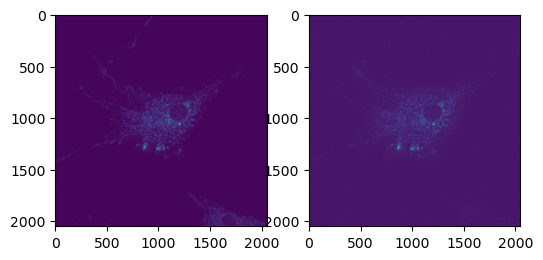

In [24]:
_,ax = plt.subplots(figsize=(6,3),ncols=2)
ax[0].imshow(gt_cur)
ax[1].imshow(pred_cur)

In [38]:
idx = np.random.randint(0,len(gt))
gt_cur = gt[idx] 
pred_cur = pred[idx]


In [39]:
print('SSIM', micro_SSIM(gt_cur , pred_cur, ri_factor=1.0, gaussian_weights=True, data_range=gt_cur.max() - gt_cur.min()))
print('SSIM zero min',micro_SSIM(gt_cur - gt_cur.min() , pred_cur-pred_cur.min(), ri_factor=1.0, gaussian_weights=True, data_range=gt_cur.max() - gt_cur.min()) )
print('MicroSSIM', micro_SSIM(gt_cur , pred_cur, ri_factor=None, gaussian_weights=True, data_range=gt_cur.max() - gt_cur.min()))
print('MicroSSIM zero min', micro_SSIM(gt_cur - gt_cur.min() , pred_cur - pred_cur.min(), ri_factor=None, gaussian_weights=True, data_range=gt_cur.max() - gt_cur.min()))

SSIM 0.9076735615428658
SSIM zero min 0.32695053525748374
MicroSSIM 0.916288532727649
MicroSSIM zero min 0.9078058354877812


In case the background is not removed, what is the alpha. I think it is less than 2. If that is the case, it then does not make sense why the performance on 1.0 is so low. 

In [42]:
ssim_dict = micro_SSIM(gt_cur , pred_cur, ri_factor=None, gaussian_weights=True, data_range=gt_cur.max() - gt_cur.min(), return_individual_components=True)

## Experiment on how the offset plays a role in performance

In [7]:
import numpy as np
from tqdm import tqdm
idx = np.random.randint(0,len(gt))
enable_ri = False
gt_cur = gt[idx] 
pred_cur = pred[idx]
ssim_arr = []
lum_arr = []
con_arr = []
str_arr = []
offset_arr = list(range(-100,300,10))
for offset in tqdm(offset_arr):
    # ssim_dict = micro_SSIM(gt_cur - gt_cur.min()+offset , 
    #                        pred_cur-pred_cur.min()+offset, 
    #                        ri_factor=None if enable_ri else 1.0, gaussian_weights=False, data_range=gt_cur.max() - gt_cur.min(), return_individual_components=True)
    ssim_dict = micro_SSIM(gt_cur - gt_cur.min(), 
                           pred_cur-pred_cur.min()+offset, 
                           ri_factor=None if enable_ri else np.array([1.0]), 
                           gaussian_weights=False, data_range=gt_cur.max() - gt_cur.min(), return_individual_components=True)

    ssim_arr.append(ssim_dict['SSIM'].mean())
    lum_arr.append(ssim_dict['luminance'].mean())
    con_arr.append(ssim_dict['contrast'].mean())
    str_arr.append(ssim_dict['structure'].mean())

100%|██████████| 40/40 [00:29<00:00,  1.38it/s]


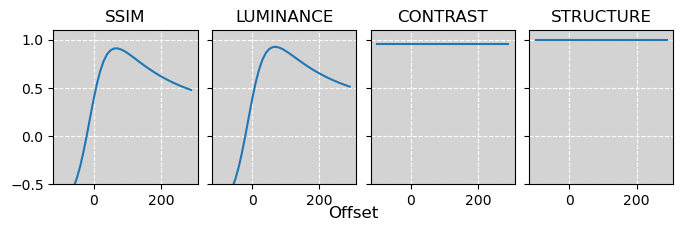

In [8]:
import matplotlib.pyplot as plt
import os
save_to_file = False and not debug_mode

fig,ax = plt.subplots(figsize=(8,2),ncols=4)
ax[0].plot(offset_arr,ssim_arr)
ax[1].plot(offset_arr,lum_arr)
ax[2].plot(offset_arr,con_arr)
ax[3].plot(offset_arr,str_arr)
# ax[3].set_yscale('log')
for ax_ in ax:
    # ax_.set_ylim([0.0,1.1])
    ax_.set_ylim([-0.5,1.1])
    ax_.grid(visible=True, color='w', linestyle='--')
    ax_.set_facecolor('lightgrey')

for ax_ in ax[1:]:
    ax_.set_yticklabels([])


plt.subplots_adjust(wspace=0.1, hspace=0.1)
ax[0].set_title('SSIM')
ax[1].set_title('LUMINANCE')
ax[2].set_title('CONTRAST')
ax[3].set_title('STRUCTURE')

fig.text(0.5, -0.06, 'Offset', ha='center', fontsize=12)

if save_to_file:
    postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'bkg_ablation_plot_Idx{idx}_{postfix}'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    plt.tight_layout()
    plt.savefig(fpath, dpi=200)
